In [1503]:
!pip install vaderSentiment

### 1. Libraries

In [1504]:
########################################
# Libraries
########################################

import os
import datetime
import numpy as np
import pandas as pd

# For Preprocessing
import re
import string
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

import pickle
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# For polarity scores labelling
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

from keras import losses
from keras import datasets
from keras.callbacks import History
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV

## For data visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
sns.set_style('darkgrid')

%matplotlib inline

# Model evaluation
from sklearn import metrics
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 2. Dataset
1. `data1_month`: Posts containing the word 'AI' from the previous months.
2. `data2_subreddits`: Posts containing 'AI' from popular subreddits and its comments.
3. `data3_subreddits`: Posts containing 'Artificial Intelligence' from popular subreddits and its comments.


In [1505]:
# Import datasets
df1 = pd.read_csv('./data1_month.csv')
df2 = pd.read_csv('./data2_subreddits.csv')
df3 = pd.read_csv('./data3_subreddits.csv')

In [1506]:
# Dimensionality of the data
print("Dimensionality of datafram 1: ", df1.shape)
print("Dimensionality of datafram 2: ", df2.shape)
print("Dimensionality of datafram 3: ", df3.shape)

Dimensionality of datafram 1:  (14159, 5)
Dimensionality of datafram 2:  (25584, 5)
Dimensionality of datafram 3:  (11055, 5)


In [1507]:
# Merge the dataframes together
df = pd.concat([df1, df2, df3])
print("Dimensionality: ", df.shape)
df.head()

Dimensionality:  (50798, 5)


,ID,Post,Author,Score,Created
0,12u4rzw,Messed around with my own Snapchat AI after se...,dross14,11620.0,1.682088e+09
1,12tucl5,"Snapchat AI “doesn’t know” my location, procee...",SpriteBleedin,6441.0,1.682063e+09
2,134jnsn,‘Godfather of AI’ quits Google with regrets an...,pstbo,45895.0,1.682940e+09
3,13457nm,When you spend 15 hours writing a 12 page case...,snowcamo53,44994.0,1.682894e+09
4,134g9zp,One of the creators of ChatGPT said that the d...,MINE_exchange,8313.0,1.682928e+09


In [1508]:
df['Length'] = df['Post'].str.split().str.len()
df = df[(df['Length'] >= 7) & (df['Length'] <= 40)].reset_index(drop=True)
df.shape

(30773, 6)

### 3. VADER Sentiment Analysis
**Introduction**: Frequently, a well-labeled training dataset may not be available to you. In those circumstances, it is necessary to employ unsupervised techniques for sentiment prediction using tools such as `VADER`.

Punctuation, capitalization, preceding trigrams, conjunctions, and other elements have an impact on scores. `VADER` performs very well with emojis, slangs and acronyms in sentences as well. Therefore, to apply `VADER`, we must do a basic preprocessing and before we do modelling, we must continue with the preprocessing such as lowercasing, etc.



In [1509]:
import warnings
warnings.filterwarnings("ignore")

# Function to clean the text of the post
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text

In [1510]:
# Apply vader to get the polarity scores for each text
analyzer = SentimentIntensityAnalyzer()
df['Post'] = df['Post'].apply(lambda x:clean(x))

scores = []

for post in df['Post']:
    score = analyzer.polarity_scores(post)
    score = score['compound']
    scores.append(score)

In [1511]:
# Transform the polarity scores into categories
sentiment = []

for score in scores:
    if score>=0.05:
        sentiment.append('Positive')
    elif score<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['Category'] = pd.Series(np.array(sentiment))

In [1512]:
df.head(3)

,ID,Post,Author,Score,Created,Length,Category
0,12u4rzw,Messed around with my own Snapchat AI after se...,dross14,11620.0,1.682088e+09,14,Negative
1,12tucl5,"Snapchat AI “doesn’t know” my location, procee...",SpriteBleedin,6441.0,1.682063e+09,25,Positive
2,134jnsn,‘Godfather of AI’ quits Google with regrets an...,pstbo,45895.0,1.682940e+09,13,Negative


### 4. Find the Overall Sentiment

In [1513]:
# Find the overral sentiment of the data using mean
scores = []

for sentence in df['Post']:
    score = analyzer.polarity_scores(sentence)
    scores.append(score)

df_scores = pd.DataFrame(scores)
print(df_scores.mean())

neg         0.085876
neu         0.795269
pos         0.116871
compound    0.065456
dtype: float64


### 5. Wordcloud Analysis of Posts

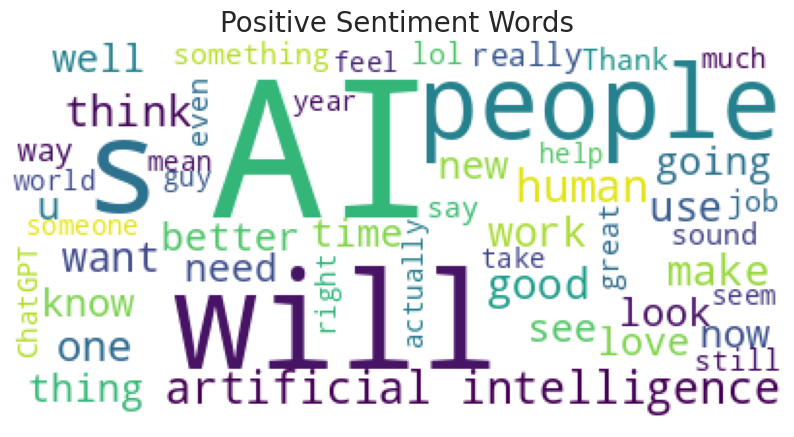

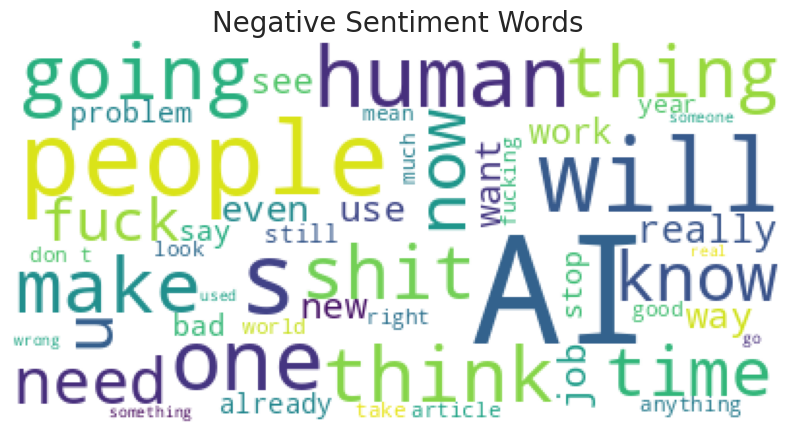

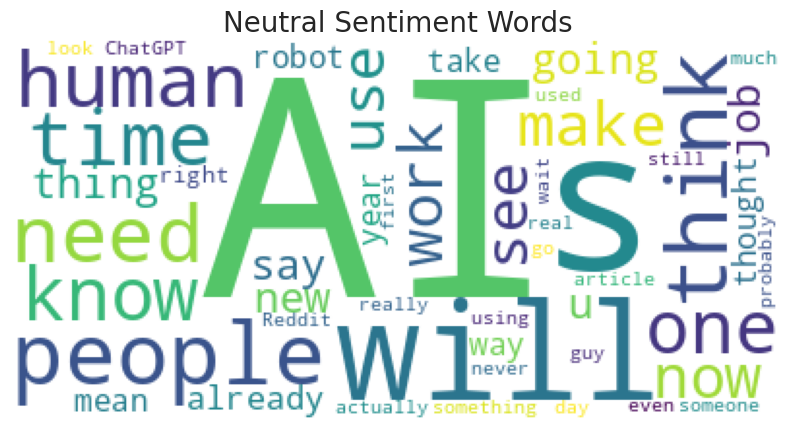

In [1514]:
# Visualizing data into wordclouds
def wordcount_gen(df, sentiment):
    # Combine all posts
    combined_posts = " ".join([post for post in df[df.Category==sentiment]['Post']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_posts))
    plt.title('{} Sentiment Words'.format(sentiment), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive post words
wordcount_gen(df, 'Positive')

# Negative post words
wordcount_gen(df, 'Negative')

# Neutral post words
wordcount_gen(df, 'Neutral')

### 6. Preprocessing: Tokenization, Stop-word and Punctuation Removal, Stemming and Lemmatization
**Stemming**: `Porter` and `Snowball`.

In [1515]:
# Removing punctuations and making text lowercase
def clean_text(text):

    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df['Post'] = df['Post'].apply(lambda x:clean_text(x))

In [1516]:
# Tokenize the posts
df_test = pd.DataFrame()
df_test['Post'] = df['Post']

def tokenization(text):
    text = re.split('\W+', text)
    return text

df_test['tokenized'] = df['Post'].apply(lambda x: tokenization(x.lower()))

In [1517]:
negative_stopwords = ['no', 'nor','not',
 'only','don',
 "don't",'ain',
 'aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]

stopwords_original = nltk.corpus.stopwords.words('english')

stopword = [word for word in stopwords_original if word not in negative_stopwords]

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df_test['No_stopwords'] = df_test['tokenized'].apply(lambda x: remove_stopwords(x))

In [1518]:
# Apply Porter Stemming
ps = nltk.PorterStemmer()

def porter_stemmer(text):
    text = [ps.stem(word) for word in text]
    return text

df_test['stemmed_porter'] = df_test['No_stopwords'].apply(lambda x: porter_stemmer(x))

In [1519]:
# Apply Snowball Stemming
s_stemmer = SnowballStemmer(language='english')

def snowball_stemmer(text):
    text = [s_stemmer.stem(word) for word in text]
    return text
df_test['stemmed_snowball'] = df_test['No_stopwords'].apply(lambda x: snowball_stemmer(x))

In [1520]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df_test['lemmatized'] = df_test['No_stopwords'].apply(lambda x: lemmatizer(x))

In [1521]:
df_test.tail()

,Post,tokenized,No_stopwords,stemmed_porter,stemmed_snowball,lemmatized
30768,we can work so that the people in the next gen...,"[we, can, work, so, that, the, people, in, the...","[work, people, next, generation, see]","[work, peopl, next, gener, see]","[work, peopl, next, generat, see]","[work, people, next, generation, see]"
30769,ill live on through my children and theyll liv...,"[ill, live, on, through, my, children, and, th...","[ill, live, children, theyll, live, see, bette...","[ill, live, children, theyll, live, see, bette...","[ill, live, children, theyll, live, see, bette...","[ill, live, child, theyll, live, see, better, ..."
30770,as a member of the dating community and a fan ...,"[as, a, member, of, the, dating, community, an...","[member, dating, community, fan, artificial, i...","[member, date, commun, fan, artifici, intellig...","[member, date, communiti, fan, artifici, intel...","[member, dating, community, fan, artificial, i..."
30771,only if you count thinking olivia wilde looked...,"[only, if, you, count, thinking, olivia, wilde...","[only, count, thinking, olivia, wilde, looked,...","[onli, count, think, olivia, wild, look, sexi,...","[onli, count, think, olivia, wild, look, sexi,...","[only, count, thinking, olivia, wilde, looked,..."
30772,i cant help but wonder if you feel as though y...,"[i, cant, help, but, wonder, if, you, feel, as...","[cant, help, wonder, feel, though, destined, g...","[cant, help, wonder, feel, though, destin, gre...","[cant, help, wonder, feel, though, destin, gre...","[cant, help, wonder, feel, though, destined, g..."


As we can see, the stemming does not perform very well since some words were truncated incorrectly. Therefore, we should use Lemmatization instead

In [1522]:
df['Post'] = df_test['lemmatized']
df['Post'] = [' '.join(map(str, l)) for l in df['Post']]

### 7. Sentiment Categories Visualization

<Axes: xlabel='Category', ylabel='count'>

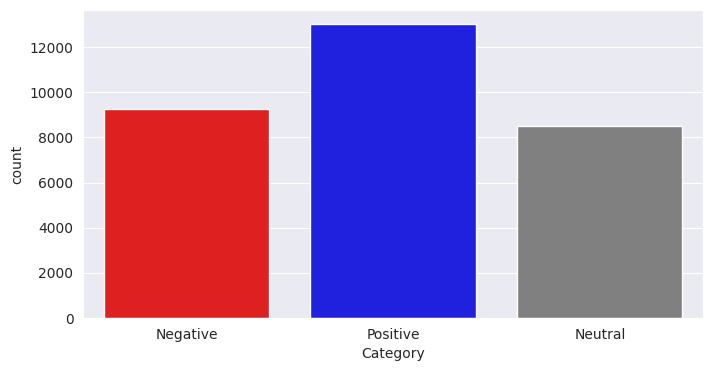

In [1523]:
plt.figure(figsize=(8,4))
sns.countplot(x='Category',data=df, palette=['red',"blue", "grey"])

In [1524]:
category_count_posts = df.groupby('Category').count()['Post'].reset_index().sort_values(by='Post',ascending=False)

fig = go.Figure(go.Funnelarea(
    text = category_count_posts.Category,
    values = category_count_posts.Post,
    title = {"position": "top center", "text": "Chart of Sentiment Distribution"}
    ))
fig.show()

#### 7.2 Time Based Analysis on Posts
We can see there is a steeper rise of positive posts in the past years compared to other categories.

In [1525]:
# remove NaN values
df = df[df['Created'].notnull()]

# Modify date to graph
def format_date(date):
  return datetime.datetime.fromtimestamp(int(date)).strftime('%Y-%m-%d %H:%M:%S')

df['Created'] = df['Created'].apply(format_date)

<Figure size 10000x1000 with 0 Axes>

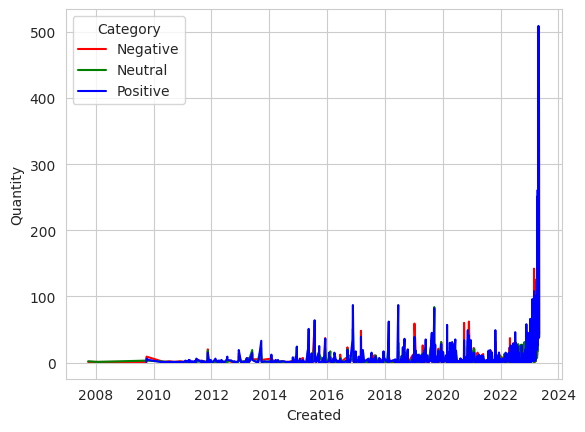

<Figure size 10000x1000 with 0 Axes>

In [1526]:
df['Created'] = pd.to_datetime(df.Created)

timeline = df.resample('D', on='Created')["Category"].value_counts().unstack(1)
timeline.reset_index(inplace=True)

timeline = timeline.melt("Created", var_name='Category',  value_name='Quantity')

sns.set_style("whitegrid")
sns.lineplot(x="Created", y="Quantity", hue="Category", data=timeline, palette=["r", "g","b"])
plt.figure(figsize=(100,10))

#### 7.4 Post Length Distribution

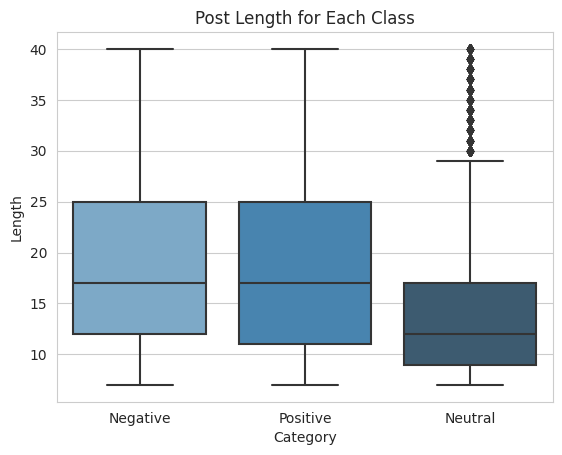

In [1527]:
# Plot the distribution of the length tweets for each class using a box plot
sns.boxplot(x = df['Category'], y = df['Length'], data = df, palette=("Blues_d"))
plt.title('Post Length for Each Class')
plt.show()

### 8. Modelling

In [1528]:
# Encode target labels
le = LabelEncoder()
X = df['Post']
Y = le.fit_transform(df['Category'])

#### 8.1 Bidirectional LSTM (Deep Learning)

##### 8.1.1 Bag of Words (BOW) Feature Extraction

In [1529]:
y = pd.get_dummies(df['Category'])

# split between train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

vocabulary_size = 5000
count_vector = CountVectorizer(max_features=vocabulary_size,
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

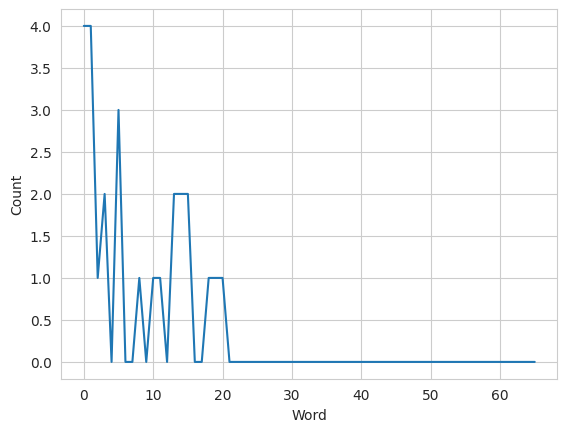

In [1530]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [1531]:
max_words = 5000
max_len = 40

def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before \n', df['Post'][10])
X, tokenizer = tokenize_pad_sequences(df['Post'])
print('After \n', X[10])

Before 
 ceo openai say current approach ai soon reach limit scaling llm model stop delivering improvement ai new approach needed
After 
 [ 308  419   37  295 1187    1  195 1388 1255 1292  160  103 1508    1
   40 1187  562    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


##### 8.1.2 Train and Test Split

In [1532]:
y = pd.get_dummies(df['Category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (24924, 40) (24924, 3)
Validation Set:  (2770, 40) (2770, 3)
Test Set:  (3078, 40) (3078, 3)


##### 8.1.3 Neural Network

In [1533]:
from keras import regularizers

vocab_size = 5000
embedding_size = 32
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.9

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# Neural network architecture
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))


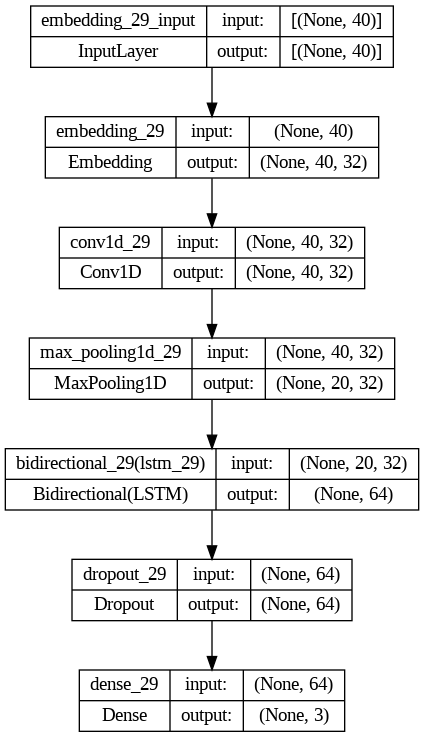

In [1534]:
# Visualize the architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [1535]:
# Compile model
model.compile(optimizer=sgd, loss='categorical_crossentropy',
               metrics=['accuracy', Precision(), Recall()])

# Train model
batch_size = 32
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
779/779 [==============================] - 26s 27ms/step - loss: 1.0011 - accuracy: 0.5037 - precision_29: 0.6283 - recall_29: 0.2487 - val_loss: 0.9269 - val_accuracy: 0.5523 - val_precision_29: 0.6692 - val_recall_29: 0.3863
Epoch 2/20
779/779 [==============================] - 20s 26ms/step - loss: 0.8090 - accuracy: 0.6533 - precision_29: 0.7214 - recall_29: 0.5163 - val_loss: 0.7761 - val_accuracy: 0.6653 - val_precision_29: 0.7124 - val_recall_29: 0.5733
Epoch 3/20
779/779 [==============================] - 19s 24ms/step - loss: 0.7071 - accuracy: 0.7152 - precision_29: 0.7454 - recall_29: 0.6381 - val_loss: 0.7105 - val_accuracy: 0.7123 - val_precision_29: 0.7388 - val_recall_29: 0.6596
Epoch 4/20
779/779 [==============================] - 23s 29ms/step - loss: 0.6420 - accuracy: 0.7554 - precision_29: 0.7711 - recall_29: 0.7171 - val_loss: 0.6623 - val_accuracy: 0.7473 - val_precision_29: 0.7607 - val_recall_29: 0.7206
Epoch 5/20
779/779 [============================

##### 8.1.4 Evaluation Metrics

In [1536]:
# Function to calculate f1 score
def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [1537]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.3f}'.format(accuracy))
print('Precision : {:.3f}'.format(precision))
print('Recall    : {:.3f}'.format(recall))
print('F1 Score  : {:.3f}'.format(f1_score(precision, recall)))

Accuracy  : 0.840
Precision : 0.849
Recall    : 0.830
F1 Score  : 0.839


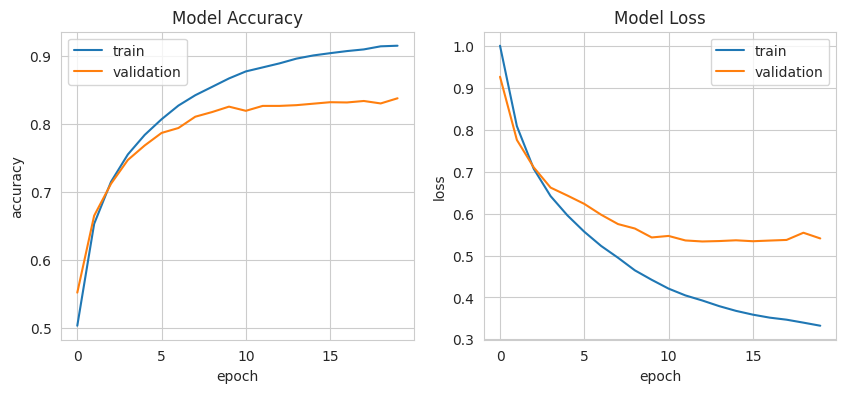

In [1538]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
# first plot
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0]. set_title('Model Accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train', 'validation'], loc='best')

# second plot
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend(['train', 'validation'], loc='best')

97/97 [==============================] - 1s 6ms/step


Text(45.722222222222214, 0.5, 'Predicted label')

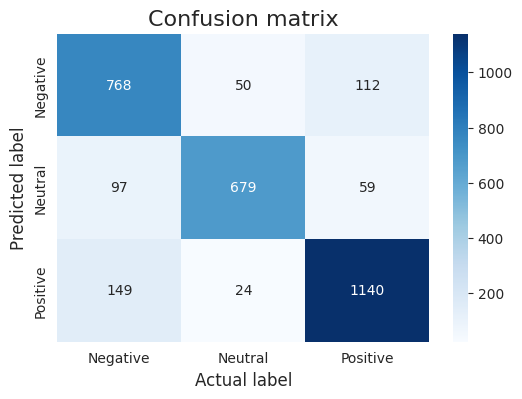

In [1539]:
sentiment_classes = ['Negative', 'Neutral', 'Positive']

# predict
y_pred = model.predict(X_test)

# compute the confusion matrix
cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

# plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)


#### 8.2 Conventional ML Models

In [1540]:
# Get the target values
X = df['Post']
y = df['Category']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

##### 8.2.1 Random Forest

In [1541]:
# Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5,
                                              n_estimators=100))])
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      2327
     Neutral       0.00      0.00      0.00      2113
    Positive       0.42      1.00      0.59      3253

    accuracy                           0.42      7693
   macro avg       0.47      0.33      0.20      7693
weighted avg       0.48      0.42      0.25      7693



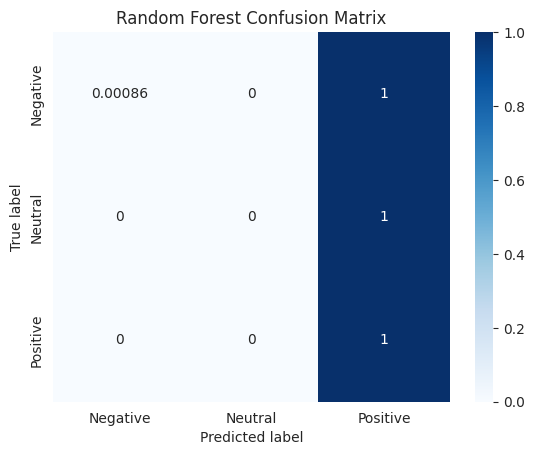

In [1542]:
# Create a classification report for the RF model
print(metrics.classification_report(y_valid, y_pred_rf))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_rf)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.2 Naive Bayes classification

In [1543]:
# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)


              precision    recall  f1-score   support

    Negative       0.80      0.48      0.60      2327
     Neutral       0.88      0.21      0.35      2113
    Positive       0.54      0.95      0.69      3253

    accuracy                           0.61      7693
   macro avg       0.74      0.55      0.54      7693
weighted avg       0.71      0.61      0.57      7693



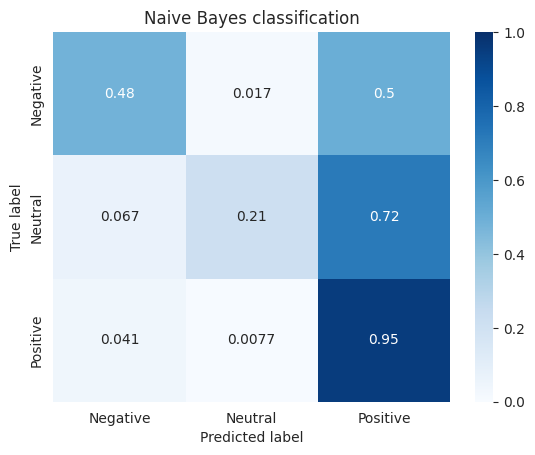

In [1544]:
# Create a classification report for the Naive Bayes model
print(metrics.classification_report(y_valid, y_pred_nb))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_nb)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Naive Bayes classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.3 K Nearest Neighbors classification¶

In [1545]:
# K-NN Classifier
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=5,
                                             metric='minkowski',
                                             p=2))])

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

              precision    recall  f1-score   support

    Negative       0.75      0.02      0.05      2327
     Neutral       0.28      0.99      0.44      2113
    Positive       0.87      0.04      0.07      3253

    accuracy                           0.29      7693
   macro avg       0.63      0.35      0.18      7693
weighted avg       0.67      0.29      0.16      7693



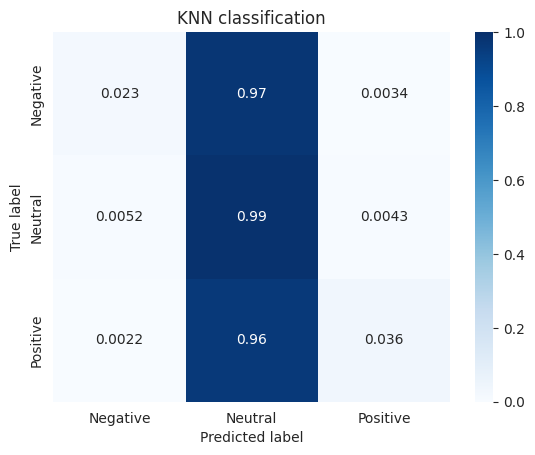

In [1546]:
# Create a classification report for the KNN model
print(metrics.classification_report(y_valid, y_pred_knn))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_knn)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('KNN classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.4 Logistic regression

In [1547]:
# Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1,
                                         class_weight='balanced',
                                         max_iter=1000))])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

              precision    recall  f1-score   support

    Negative       0.79      0.72      0.75      2327
     Neutral       0.72      0.88      0.79      2113
    Positive       0.86      0.79      0.82      3253

    accuracy                           0.79      7693
   macro avg       0.79      0.79      0.79      7693
weighted avg       0.80      0.79      0.79      7693



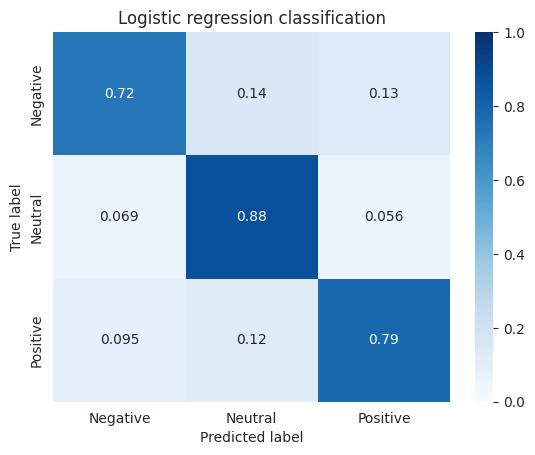

In [1548]:
# Create a classification Report for the model
print(metrics.classification_report(y_valid, y_pred_lr))

cm = confusion_matrix(y_valid, y_pred_lr)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Heatmap for the results
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Logistic regression classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### 8.2.5 Linear SVC classification

In [1549]:
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC())])

lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

              precision    recall  f1-score   support

    Negative       0.82      0.74      0.78      2327
     Neutral       0.79      0.83      0.81      2113
    Positive       0.83      0.86      0.84      3253

    accuracy                           0.82      7693
   macro avg       0.81      0.81      0.81      7693
weighted avg       0.82      0.82      0.81      7693



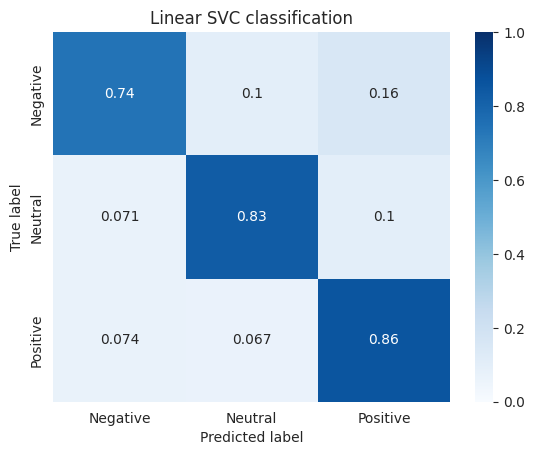

In [1550]:
# Create the classification Report for the linear SVC model
print(metrics.classification_report(y_valid, y_pred_lsvc))

# Create a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_lsvc)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, cmap=plt.cm.Blues, annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes,
            vmin=0.,
            vmax=1.)

# Adding lables
plt.title('Linear SVC classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### 9. Prediction

In [1551]:
# Saving file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Open file to use
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [1552]:
# Function for predictions

def predict_class(text):
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transform the text to a sequence of integers
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Predict using the model
    yt = model.predict(xt).argmax(axis=1)

    print('The predicted category is', sentiment_classes[yt[0]])

In [1553]:
predict_class(["I love a lot ai"])
predict_class(["AI will bring more problems to our society than benefits!!"])
predict_class(["AI studies is increasing over time"])

1/1 [==============================] - 1s 861ms/step
The predicted category is Positive
1/1 [==============================] - 0s 23ms/step
The predicted category is Neutral
1/1 [==============================] - 0s 23ms/step
The predicted category is Neutral
